In [1]:
!gdown --id 1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP
From (redirected): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP&confirm=t&uuid=ef422841-b0e6-4e54-977e-6428554357a0
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 45.4MB/s]


In [2]:
!unzip -q "/content/FER-2013.zip"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [4]:
batch_size = 256
img_height = 180
img_width = 180
image_count = 28709
train_dir = "/content/train"
val_dir = "/content/test"

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.img_dir = img_dir
        self.classes = os.listdir(img_dir)
        self.image_files = [(os.path.join(cls, img), cls) for cls in self.classes for img in os.listdir(os.path.join(img_dir, cls))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx:cls  for cls, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, cls = self.image_files[idx]
        image = self.resize(read_image(os.path.join(self.img_dir, img_path)))
        image = image.type(torch.float32)
        label = self.class_to_idx[cls]
        if self.norm:
            image = (image/127.5) - 1
        return image, label

In [6]:
train_dataset = ImageDataset(train_dir, True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(val_dir, True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

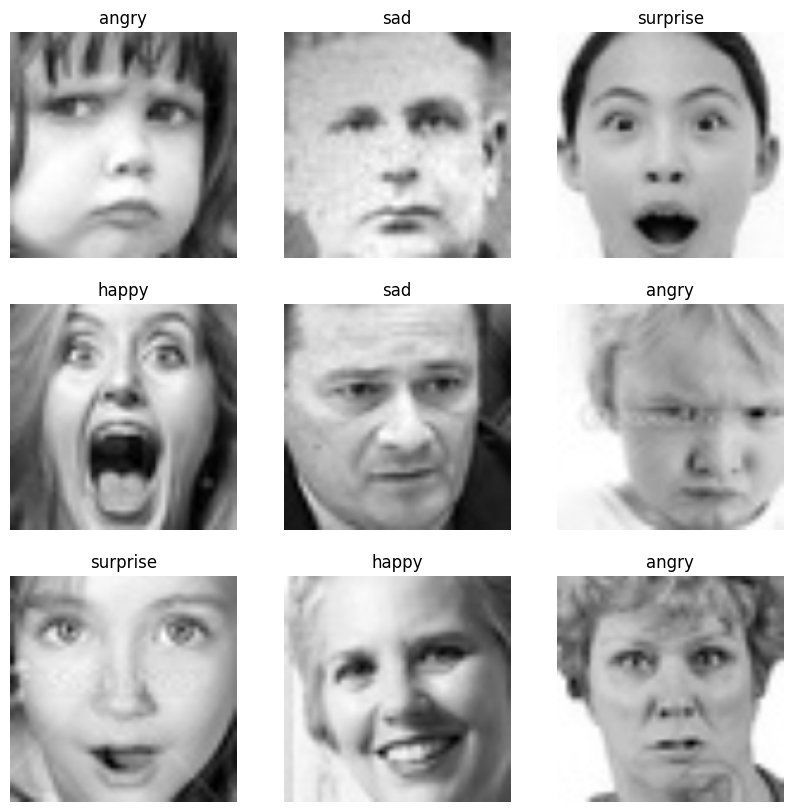

In [7]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
  label = label_batch[i]
  plt.title(train_dataset.idx_to_class[label.item()])
  plt.axis("off")

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

model = MLP(input_dims=180*180, hidden_dims=256, output_dims=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006)

In [9]:
num_epochs = 100
train_losses = []
train_acc = []
val_losses = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    accuracy = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy /= cnt
    train_acc.append(accuracy)


    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    cnt = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_accuracy += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy /= cnt
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Train_Acc: {accuracy:.4f}, Val_Loss: {val_loss:.4f},  Val_Acc: {val_accuracy:.4f}")

Epoch 1/100, Train_Loss: 1.9057,  Train_Acc: 0.2497, Val_Loss: 1.8524,  Val_Acc: 0.2471
Epoch 2/100, Train_Loss: 1.8294,  Train_Acc: 0.2513, Val_Loss: 1.7917,  Val_Acc: 0.2470
Epoch 3/100, Train_Loss: 1.7927,  Train_Acc: 0.2584, Val_Loss: 1.7684,  Val_Acc: 0.2657
Epoch 4/100, Train_Loss: 1.7714,  Train_Acc: 0.2794, Val_Loss: 1.7490,  Val_Acc: 0.2797
Epoch 5/100, Train_Loss: 1.7539,  Train_Acc: 0.2979, Val_Loss: 1.7309,  Val_Acc: 0.3020
Epoch 6/100, Train_Loss: 1.7353,  Train_Acc: 0.3156, Val_Loss: 1.7109,  Val_Acc: 0.3321
Epoch 7/100, Train_Loss: 1.7122,  Train_Acc: 0.3348, Val_Loss: 1.6845,  Val_Acc: 0.3408
Epoch 8/100, Train_Loss: 1.6899,  Train_Acc: 0.3472, Val_Loss: 1.6603,  Val_Acc: 0.3530
Epoch 9/100, Train_Loss: 1.6664,  Train_Acc: 0.3574, Val_Loss: 1.6417,  Val_Acc: 0.3618
Epoch 10/100, Train_Loss: 1.6486,  Train_Acc: 0.3644, Val_Loss: 1.6269,  Val_Acc: 0.3703
Epoch 11/100, Train_Loss: 1.6341,  Train_Acc: 0.3702, Val_Loss: 1.6120,  Val_Acc: 0.3749
Epoch 12/100, Train_Loss: 1.62

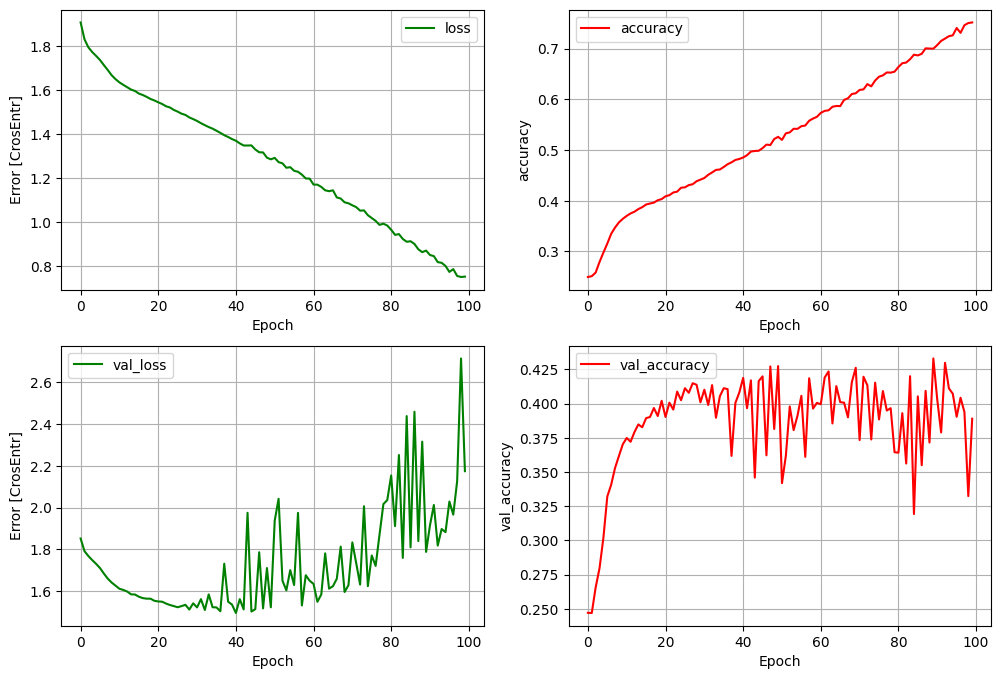

In [10]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(train_acc, label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(val_losses, label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(val_acc, label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)
